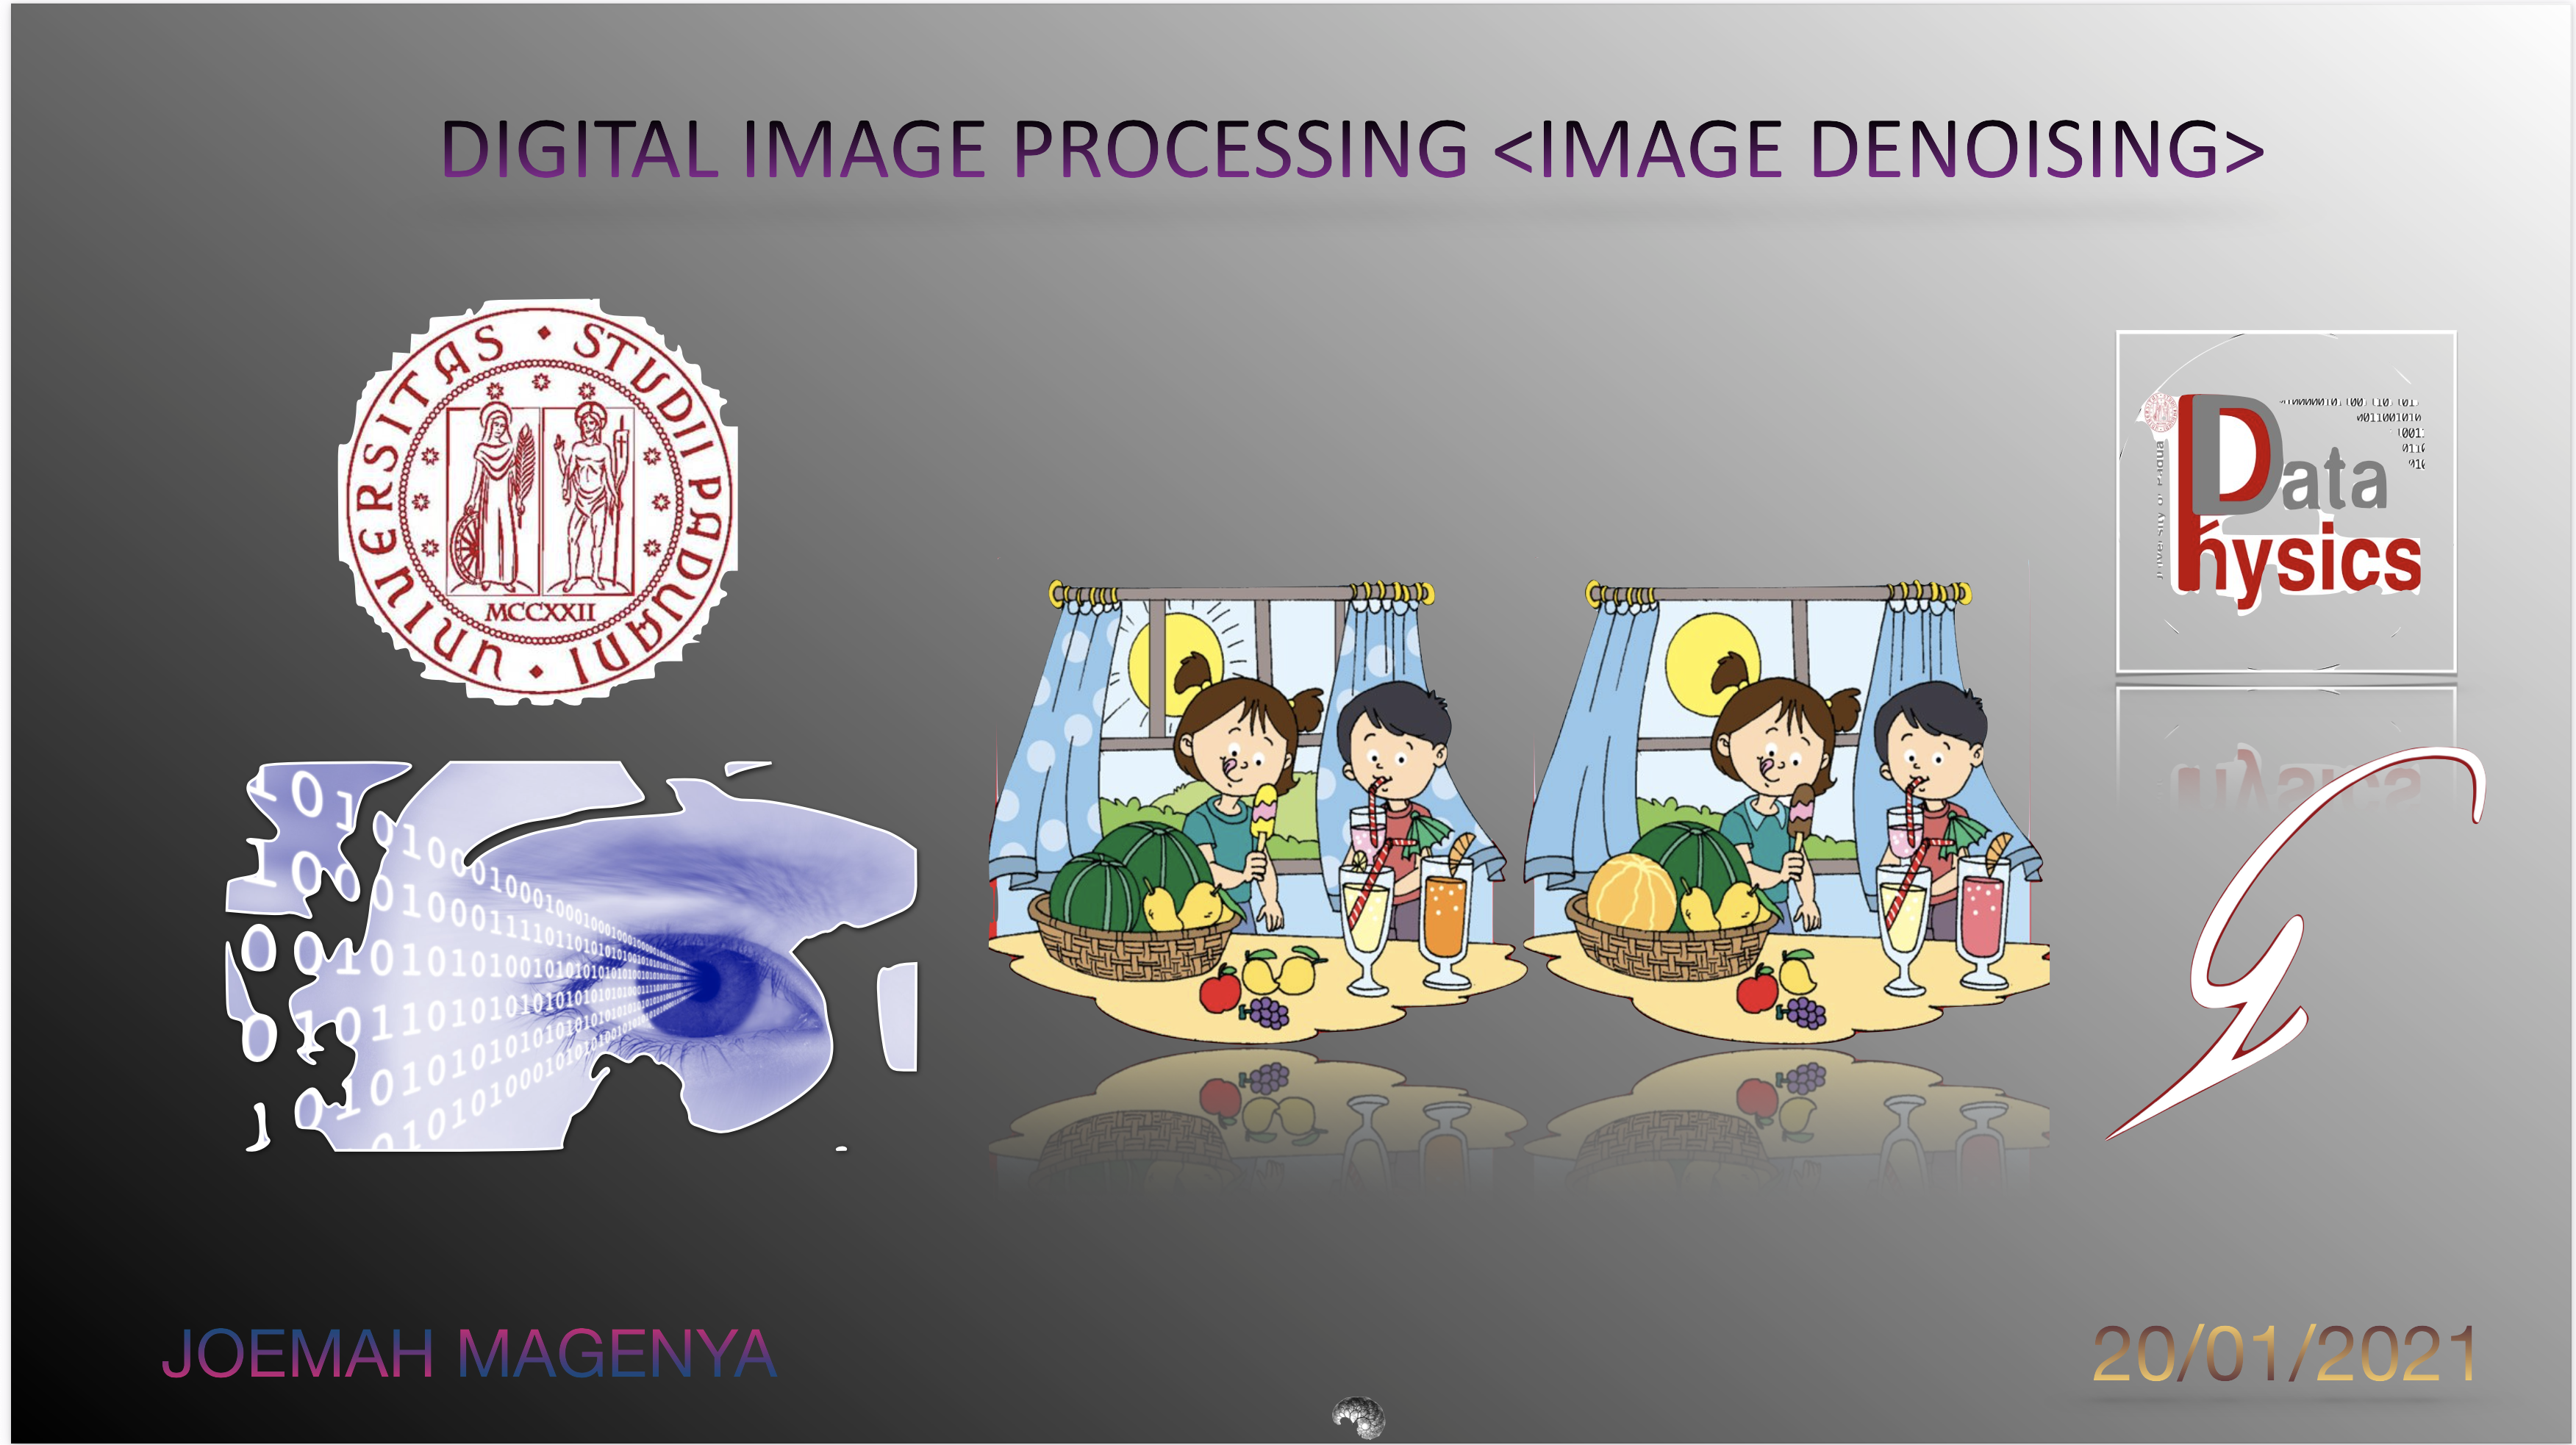

# Dataset 
each image file is such that::
- File names are organized in such a manner that they indicate a number of the reference image, then a number of distortion's type, and, finally, a number of distortion's level: "iXX_YY_Z.bmp". 


# AIM
-  to extract a clean image  from the noisy image

 - A noise is introduced in the transmission medium due to a noisy channel, errors during the measurement process and during quantization of the data for digital storage. Each element in the imaging chain such as lenses, film, digitizer, etc. contribute to the degradation. Image denoising is often used in the field of photography or publishing where an image was somehow degraded but needs to be improved before it can be printed.

- Image denoising finds applications in fields such as astronomy where the resolution limitations are severe, in medical imaging where the physical requirements for high quality imaging are needed for analyzing images of unique events, and in forensic science where potentially useful photographic evidence is sometimes of extremely bad quality
- Noise can be additive or multiplicative
- by image multiplication, the brightness of the image is varied.

In [1]:
from  skimage.io  import imread
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, normalized_root_mse
from scipy import signal
from  scipy.ndimage import median_filter

In [2]:
%matplotlib inline 

In [3]:
import random
random.seed(500)

In [4]:
ref_data = 'data/reference_images/'
data_files = 'data/distorted_images/'

In [5]:
ref1_images = [ref_data+'I'+str(0)+str(i)+'.BMP' for i in range(1, 10)] # save reference images in an array
ref2_images = [ref_data+'I'+str(i)+'.BMP' for i in range(10, 26)] # save reference images in an array
ref_images = ref1_images + ref2_images

# Noise Models

###  Distortion type

- 1  -> Additive Gaussian noise
- 2  -> Additive noise in color components is more intensive than additive noise in the luminance component
- 3  -> Spatially correlated noise
- 4  -> Masked noise
- 5  -> High frequency noise
- 6  -> Impulse noise
- 7  -> Quantization noise
- 14 -> Non eccentricity pattern noise
- 19 -> Multiplicative Gaussian noise
- 20 -> Comfort noise

In [6]:
dist_cod = ['0'+str(i) for i in range(1, 8)]
dis_co = [str(14), str(19), str(20)]
dist_code = dist_cod + dis_co

In [7]:
distorted_images1 = [data_files+'i'+str(0)+str(i)+'_'+j+'_'+str(k)+'.bmp' # select distorted images with 
          for i in range(1, 10) for j in dist_code for k in range(1, 6)] #  distortion given by  the 'code'
distorted_images2 = [data_files+'i'+str(i)+'_'+j+'_'+str(k)+'.bmp' # select distorted images with 
          for i in range(10, 26) for j in dist_code for k in range(1, 6)] #  distortion given by  the 'code'
distorted_images = distorted_images1 + distorted_images2

## Read Images

In [8]:
def read_images(image_array):
    """
        Function to  read images
        input: image_array -> an array containing string image files 
        return: images as an array
    """
    images = []
    for i in range(len(image_array)):    
        imag = imread(image_array[i])
        images.append(imag)
    return images

In [9]:
def get_dist_images(data_files, dist_type):
    distorted_images1 = [data_files+'i'+str(0)+str(i)+'_'+ dist_type+'_'+str(k)+'.bmp' # select distorted images with 
          for i in range(1, 10) for k in range(1, 6)] #  distortion given by  the 'code'
    
    distorted_images2 = [data_files+'i'+str(i)+'_'+dist_type+'_'+str(k)+'.bmp' # select distorted images with 
          for i in range(10, 26)  for k in range(1, 6)] #  distortion given by  the 'code'
    dist_images =  read_images(distorted_images1 + distorted_images2)
    return dist_images

In [10]:
add_gauss_images = get_dist_images(data_files, '07')

In [11]:
orig_images = read_images(ref_images)

In [12]:
#dist_images = read_images(distorted_images)

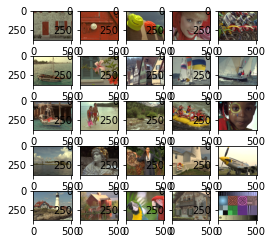

In [13]:
fig = plt.figure(figsize = (4 , 4))
for i, n in enumerate(ref_images):
    ax = fig.add_subplot(5,5,i+1)
    plt.imshow(orig_images[i])

# Metrics  
For testing the two popular and widely  used metrics to  evalaute the perfomance are:
- peak-to-signal-noise-ratio (PSNR) 
- mean square error (MSE)



### MSE
- the square of difference between the pixel values of the original image and denoised image. 
\begin{align*}
\\
MSE = \dfrac{1}{mn} \sum\limits_{m=0}^{m-1}{\sum\limits_{n=0}^{n-1}[f(i,j)- g(i,j)}]^2
\\
\end{align*}

- f represents the matrix data of our original image
- g represents the matrix data of our degraded image in question
-  m represents the numbers of rows of pixels of the images and i represents the index of that row
- n represents the number of columns of pixels of the image and j represents the index of that column
- M- AXf is the maximum signal value that exists in our original “known to be good” image
- the higher the MSE value, the  lower the denoised image quality. Hence, lower value of MSE indicates good denoising technique performance.


In [14]:
def MSE(orig_image, comp_image):
    
    """
    ** split a color image into its 3 RGB channels then calculate their MSE
    
    Input:
        orig_image --> represents the original  image
        comp_image --> represents the image to  be compared to  the original  image
    
    Output:
        mse (value) --> mean squared error between the two images.
    """
    height, width, channel = orig_image.shape # get the height, width and number of channels
    
    size = height*width # compute the area of the image
    
    b1, g1, r1 = cv2.split(orig_image) # split the image into individual channels
    b2, g2, r2 = cv2.split(comp_image) 
    
    mseb = np.sum((b1 - b2)**2)
    mser = np.sum((r1 - r2)**2)
    mseg = np.sum((g1 - g2)**2) ## compute the mse for each  color channel
    
    mse = (mseb + mser + mseg)/(3*size) # compute the overal  mse
     
    return mse

In [15]:
def split_channels(image):
    """
    Funtion to  split the channels of an image into individual channels i.e R, G, B 
    
    Input:
        image rgb image whose channels are to  be split
        
    Output:
        returns individual channels, R, G, B
    """
    r = image[:,:,0]  # Extract r channel
    g = image[:,:,1]  # Extract g channel
    b = image[:,:,2]  # Extract b channel
    
    return r, g, b

# SNR

In [16]:
def signal_to_noise(orig_image, comp_image):
    """
    Function to  compute the signal to  noise ratio.
    input:
        orig_image ---> the original image
        comp_image ---> image to  be compared to  the original image i.e. (noise | denoised)
    output: 
        value (snr)
    """
    height = orig_image.shape[0] # number of image rows
    width = orig_image.shape[1]  # number of image columns
    
    r1, g1, b1 = split_channels(orig_image) # get  the individual channels for the original image
    r2, g2, b2 = split_channels(comp_image) # get  the individual channels for the query  image
    
    # compute the mean squared error for
    r_mse = np.sum((r1 - r2)**2)
    g_mse = np.sum((g1 - g2)**2)
    b_mse = np.sum((b1 - b2)**2)
    
    mse = (r_mse + g_mse + b_mse)/(3*height*width) # compute the overal  mse

    dv = np.sum((np.var(r1) + np.var(g1) + np.var(b1))/3)
    
    with np.errstate(divide='ignore'):
        rt = dv / mse
    return 10.0 * np.log10(rt)

## Peak signal-to-noise ratio (PSNR) : 
- PSNR, is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation
- PSNR is most easily defined via the mean squared error (MSE). Given a noise-free m×n monochrome image I and its noisy approximation K, MSE is defined as:


- To assess the quality  of the denoised image, compute PSNR between the original image
    and the denoised image. 
- measure of signal power compared to  noise power. 
- the hight the ratio, the higher the visual quality of the image.
- mathematically 
-  The PSNR is a logarithmic error measure of the 
    difference between two  images based on the mean-squared-error (MSE).

\begin{align*}
\\
PNSR = 10\log_{10}{(\dfrac{L^2}{MSE})}
\\
\end{align*}

In [17]:
def PSNR(orig_image, comp_image, flag=False): 
    """ 
        computes the peak to  signal  ratio  between two  images
        
        Input::
            orig_image --> original image
            comp_image --> image in comparizon to  the original image
        
        Output:
            psnr (value)
    """
    mse = MSE(orig_image, comp_image)
    if flag == True:
        print('The mse value after filtering is:', mse)
    if(mse == 0): 
        return 100
    max_pixel = 255.0 # is maximum value of pixel
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    if flag == True:
        print('The pnsr value after filtering is:', round(psnr,2))
    return round(psnr, 2)  

# Structural Similarity Index Measure (SSIM)

The difference with respect to other techniques mentioned previously such as MSE or PSNR is that these approaches estimate absolute errors; on the other hand, SSIM is a perception-based model that considers image degradation as perceived change in structural information, while also incorporating important perceptual phenomena, including both luminance masking and contrast masking terms. Structural information is the idea that the pixels have strong inter-dependencies, especially when they are spatially close. These dependencies carry essential information about the structure of the objects in the visual scene. Luminance masking is a phenomenon whereby image distortions (in this context) tend to be less visible in bright regions, while contrast masking is a phenomenon whereby distortions become less visible where there is a significant activity or "texture" in the image: 
\begin{align*}
\\
SSIM(x,y) = {\dfrac{(2\mu_{x}\mu_{y} + c_{1})(2\sigma_{xy} +c_{2})}{(\mu^2_{x}+\mu^2_{y}+c_{1})(\sigma^2_{x}+\sigma^2_{y}+c_{2})}}
\end{align*}

In [18]:
def SSIM(ref_image, comp_image):
    """
    Compute the structural  similarity index between two images
    
    Input:
        ref_image, comp_image: ndarray --> images of the same shape
    
    Output:
        return:
            ssim (value) index 
            --> The resultant SSIM index is a decimal value between -1 and 1, 
            and value 1 is only reachable in the case of 
            two identical sets of data and therefore indicates perfect structural similarity
            --> A value of 0 indicates no structural similarity
    """
    ssim = structural_similarity(ref_image,comp_image, data_range=255, multichannel=True)
    
    return round(ssim, 2)

def write_csv(n,data):
    with open('PSNR-result/'+n+'.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(data)

for i in range(6):
    print("Creating CSV of PSNR-result",i+1,"...",sep="")
    write_csv(str(i+1),[calculate_psnr(str(i+1))])

In [19]:
#comp_images[values[i]:values[i+1]]
def group_data(add_gauss_images):
    """Group the images into  an array containing an image with distortion levels"""
    values  = [i*5 for i in range(1,26)]
    comp = []
    comp1 = []
    for i in range(0, 5):
        comp1.append(add_gauss_images[i])
    for i in range(1, 25):
        comp_images = add_gauss_images[values[i-1]:values[i]]
        comp.append(comp_images)
    comp.insert(0, comp1)
    
    return comp

##  Funtions to Compute Metrics 

In [20]:
def compute_metric_values(orig_images, comp,Metric, filter_method=True):
    """
    Compute the PSNR values for different levels of distotions
    
        orig_image:: the undistorted original image
        comp_images:: an array containing images with different levels of distortion
        filter_method:: the method to used to perform the filtering
    """
    #kernel_sizes = [i+2 for i in range(1,100) if i%2!=0]
    #values  = [i*5 for i in range(1,26)]
    metric_values1 = []
    metric_values2 = []
    metric_values3 = []
    metric_values4 = []
    metric_values5 = []    
    for i, image in enumerate(orig_images):
        comp_images = comp[i]
        # distoration level 1
        if filter_method:
            kernel_size = 7
            den_image1 = filter_method(comp_images[0],kernel_size)
            met = Metric(image, den_image1)
            metric_values1.append(met)

            # distortion level 2
            den_image2 = filter_method(comp_images[1],kernel_size)
            met = Metric(image, den_image2)
            metric_values2.append(met)

            # distortion level 3
            den_image3 = filter_method(comp_images[2],kernel_size)
            met = Metric(image, den_image3)
            metric_values3.append(met)

            # distotion level 4
            den_image4 = filter_method(comp_images[3],kernel_size)
            met = Metric(image, den_image4)
            metric_values4.append(met)

            # distotion level 5
            den_image5 = filter_method(comp_images[4],kernel_size)
            met = Metric(image, den_image5)
            metric_values5.append(met)
            
        else:
            met = Metric(image, comp_images[0])
            metric_values1.append(met)
            met = Metric(image, comp_images[1])
            metric_values2.append(met)
            met = Metric(image, comp_images[2])
            metric_values3.append(met)
            met = Metric(image, comp_images[3])
            metric_values4.append(met)
            met = Metric(image, comp_images[4])
            metric_values5.append(met)
    
    return metric_values1, metric_values2, metric_values3, metric_values4,metric_values5#, kernel_sizes

In [21]:
def compute_kern_metric_values(orig_image, comp_images,Metric, filter_method):
    """
    Compute the PSNR values for different levels of distotions
    
        orig_image:: the undistorted original image
        comp_images:: an array containing images with different levels of distortion
        filter_method:: the method to used to perform the filtering
    """
    kernel_sizes = [i+2 for i in range(1,100) if i%2!=0]
    metr_values1 = []
    metr_values2 = []
    metr_values3 = []
    metr_values4 = []
    metr_values5 = []
    for kernel_size in kernel_sizes:       
        # distoration level 1
        den_image1 = filter_method(comp_images[0],kernel_size)
        metr = Metric(orig_image, den_image1)
        metr_values1.append(metr)
        
        # distortion level 2
        den_image2 = filter_method(comp_images[1],kernel_size)
        metr = Metric(orig_image, den_image2)
        metr_values2.append(metr)
        
        # distortion level 3
        den_image3 = filter_method(comp_images[2],kernel_size)
        metr = Metric(orig_image, den_image3)
        metr_values3.append(metr)
        
        # distotion level 4
        den_image4 = filter_method(comp_images[3],kernel_size)
        metr = Metric(orig_image, den_image4)
        metr_values4.append(metr)        
        # distotion level 5
        den_image5 = filter_method(comp_images[4],kernel_size)
        metr = Metric(orig_image, den_image5)
        metr_values5.append(metr)    
    return metr_values1, metr_values2, metr_values3, metr_values4,metr_values5, kernel_sizes

# Plotting Functions

In [22]:
def plot_images(orig_imag, dist_image, comp_image, tittle):
    
    """
        Function  to  plot images.
        
    """
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(orig_imag)
    plt.title('Original Image', fontsize=10)

    plt.subplot(1, 3, 2)
    plt.imshow(dist_image)
    plt.title('Distorted Image', fontsize=10)
    
    plt.subplot(1, 3, 3)
    plt.imshow(comp_image)
    plt.title(tittle, fontsize=10)
    plt.tight_layout(True)
    plt.show()


In [23]:
def plot_intensity_distributions(images):
    fig = plt.figure(figsize = (20 , 15))
    for i, n in enumerate(images):
        ax = fig.add_subplot(3,3,i+1)
        plt.hist(images[i].ravel(), bins = 256, color = '#c47010', )
        plt.hist(images[i][:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
        plt.hist(images[i][:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
        plt.hist(images[i][:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
        #ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
        ax.set_ylabel("Count")
        if i == 0:
            ax.set_title('Intensity Distribution The original Image')
        else:
            ax.set_title("Intensity  distribution for distotion level = {} ".format(i))
        ax.set_xlabel("Intensity")
        ax.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'], loc='best')
    plt.tight_layout()

In [24]:
def plot_kernel_size_metrics(orig_image, comp_images,metric1,metric2, filter_method, title1, title2):
    """
        Plots the Metric values at different levels with respect to the kernel size
    """
    psnr_values1, psnr_values2, psnr_values3, psnr_values4,psnr_values5, kernel_size = compute_kern_metric_values(orig_image, comp_images,metric1, filter_method)
    ssim_values1, ssim_values2, ssim_values3, ssim_values4,ssim_values5, kernel_size = compute_kern_metric_values(orig_image, comp_images,metric2, filter_method)
    plt.figure(figsize=(20, 4), dpi=120)
    plt.subplot(1,2, 1)
    plt.plot(kernel_size, psnr_values1, '-', label='distotion level1')
    plt.plot(kernel_size, psnr_values2, '-.', label='distotion level2')
    plt.plot(kernel_size, psnr_values3, ':', label='distotion level3')
    plt.plot(kernel_size, psnr_values4, '--', label='distotion level4')
    plt.plot(kernel_size, psnr_values5, '+',label='distostion level5' )
    plt.xlabel('kernel_size', fontsize=20)
    plt.ylabel('PSNR', fontsize=20)
    plt.title(title1, fontsize=20)
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(kernel_size, ssim_values1, '-', label='distotion level1')
    plt.plot(kernel_size, ssim_values2, '-.', label='distotion level2')
    plt.plot(kernel_size, ssim_values3, ':', label='distotion level3')
    plt.plot(kernel_size, ssim_values4, '--', label='distotion level4')
    plt.plot(kernel_size, ssim_values5, '+',label='distotion level5' )
    plt.xlabel('kernel_size', fontsize=20)
    plt.ylabel('SSIM', fontsize=20)
    plt.title(title2, fontsize=20)
    plt.legend()
    plt.show()
    #plt.tight_layout()

def plot_all_images_metrics(orig_image, comp_images,metric, filter_method, title1, title2, label):
    """
        Plots the Metric values at different levels with respect to the kernel size
    """
    metric_values1, metric_values2, metric_values3, metric_values4,metric_values5 = compute_metric_values(orig_images, comp_images,metric, filter_method)
    dpsnr_values1, dpsnr_values2, dpsnr_values3, dpsnr_values4,dpsnr_values5 = compute_metric_values(orig_images, comp_images,metric, filter_method=False)
    plt.figure(figsize=(20, 4), dpi=120)
    plt.subplot(1,2, 1)
    plt.plot(range(len(orig_images)), metric_values1, 'bo-', label='distotion level1')
    plt.plot(range(len(orig_images)), metric_values2, 'ro-.', label='distotion level2')
    plt.plot(range(len(orig_images)), metric_values3, 'go:', label='distotion level3')
    plt.plot(range(len(orig_images)), metric_values4, 'ko--', label='distotion level4')
    plt.plot(range(len(orig_images)), metric_values5, 'yo-',label='distostion level5' )
    plt.xlabel('Number of images', fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.title(title1, fontsize=20)
    #plt.legend(loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(range(len(orig_images)), dpsnr_values1, 'bo-', label='distotion level1')
    plt.plot(range(len(orig_images)), dpsnr_values2, 'ro-.', label='distotion level2')
    plt.plot(range(len(orig_images)), dpsnr_values3, 'go:', label='distotion level3')
    plt.plot(range(len(orig_images)), dpsnr_values4, 'ko--', label='distotion level4')
    plt.plot(range(len(orig_images)), dpsnr_values5, 'yo-',label='distotion level5' )
    plt.xlabel('Number of images', fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.title(title2, fontsize=20)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [25]:
def plot_all_images_metrics(orig_image, comp_images,metric, filter_method, title1, title2, label):
    """
        Plots the Metric values at different levels with respect to the kernel size
    """
    metric_values1, metric_values2, metric_values3, metric_values4,metric_values5 = compute_metric_values(orig_images, comp_images,metric, filter_method)
    dpsnr_values1, dpsnr_values2, dpsnr_values3, dpsnr_values4,dpsnr_values5 = compute_metric_values(orig_images, comp_images,metric, filter_method=False)
    plt.figure(figsize=(20, 8), dpi=120)
    plt.subplot(1,2, 1)
    plt.stem(dpsnr_values1,linefmt='bo-', markerfmt='D', label='distotion level1',basefmt=None, use_line_collection=True)
    plt.stem(dpsnr_values2, linefmt='ro-.', markerfmt='d',label='distotion level2', basefmt=None, use_line_collection=True)
    plt.stem(dpsnr_values3, linefmt='go:', markerfmt='s',label='distotion level3', basefmt=None, use_line_collection=True)
    plt.stem(dpsnr_values4, linefmt='ko--', markerfmt='p',label='distotion level4', basefmt=None, use_line_collection=True)
    plt.stem(dpsnr_values5, linefmt='yo-', markerfmt='8', label='distotion level5',basefmt=None, use_line_collection=True)
    plt.xlabel('Image Number', fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.title(title2, fontsize=20)
    plt.grid(True)
     #plt.legend(loc='upper left')
    
    plt.subplot(1,2,2)
    plt.stem(metric_values1,linefmt='bo-', markerfmt='D', label='distotion level1', basefmt=None,  use_line_collection=True)
    plt.stem(metric_values2, linefmt='ro-.', markerfmt='d', label='distotion level2',basefmt=None, use_line_collection=True)
    plt.stem(metric_values3, linefmt='go:', markerfmt='s', label='distotion level3',basefmt=None, use_line_collection=True)
    plt.stem(metric_values4,linefmt='ko--', markerfmt='p', label='distotion level4',basefmt=None,  use_line_collection=True)
    plt.stem( metric_values5, linefmt='yo-', markerfmt='8',label='distotion level5', basefmt=None,use_line_collection=True)
    plt.xlabel('Image Number', fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.title(title1, fontsize=20)
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [27]:
def denoised_images(orig_image, comp_images, filter_method):
    """
    Compute the PSNR values for different levels of distotions
    
        orig_image:: the undistorted original image
        comp_images:: an array containing images with different levels of distortion
        filter_method:: the method to used to perform the filtering
    """
    kernel_sizes = [i+2 for i in range(1,100) if i%2!=0]
    den_images = []
    for kernel_size in kernel_sizes:       
        # distoration level 1
        den_image1 = filter_method(comp_images[0],kernel_size)
        den_images.append(den_image1)
        
        # distortion level 2
        den_image2 = filter_method(comp_images[1],kernel_size)
        den_images.append(den_image2)
        
        # distortion level 3
        den_image3 = filter_method(comp_images[2],kernel_size)
        den_images.append(den_image3)
        
        # distotion level 4
        den_image4 = filter_method(comp_images[3],kernel_size)
        den_images.append(den_image4)
        
        # distotion level 5
        den_image5 = filter_method(comp_images[4],kernel_size)
        den_images.append(den_image5)
    return den_images

## Digital Filtering

In [28]:
def mean_filter(dist_image, kernel_size):
    """
    A mean filter acts on an image by smoothing it. 
    It reduces the intensity variation between adjacent pixels. 
    The mean filter is nothing but a simple sliding window spatial 
    filter that replaces the center value in the window with
    the average of all the neighboring pixel values including itself. 
    By doing this, it replaces pixels,
    that are unrepresentative of their surroundings. 
    It is implemented with a convolution mask,
    """
     # convert the the RGB image to  HSV
    hsv_image = cv2.cvtColor(dist_image, cv2.COLOR_RGB2HSV)
    ## apply the gaussian filter
    new_image = cv2.blur(hsv_image, (kernel_size, kernel_size))
    # convert back the filtered  imge to  RGB color space
    mean_den_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    return mean_den_image

In [29]:
def median_filter(dist_image, kernel_size):
    """
    A median filter is basically a nonlinear type filter unlike mean filter. 
    The median filter also follows the moving window principle similar to the mean filter.
    A 3× 3, 5× 5, or 7× 7 kernel of pixels is scanned over pixel matrix of the entire image.
    The median of the pixel values in the window is computed, and the center pixel of the window 
    is replaced with the computed median. Median filtering is done by, first sorting all the pixel 
    values from the surrounding neighborhood into numerical order and then replacing 
    the pixel being considered with the middle pixel value.
    ** gets all the values inside a mask, sorts them and then assigns the mean value to the coordinate.
    """
    hsv_image = cv2.cvtColor(dist_image, cv2.COLOR_RGB2HSV)
    new_image = cv2.medianBlur(hsv_image, kernel_size)
    med_den_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    
    return med_den_image

In [30]:
def gaussian_filter(dist_image, kernel_size):
    """
    The width and the height of the kernel hould be specified, 
    which  should be positive and odd.
    Specify the standard deviation in both X and Y directions
    """
    # convert the the RGB image to  HSV
    hsv_image = cv2.cvtColor(dist_image, cv2.COLOR_RGB2HSV)
    ## apply the gaussian filter
    new_image = cv2.GaussianBlur(hsv_image, (kernel_size, kernel_size), 0)
    # convert back the filtered  imge to  RGB color space
    gaus_den_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    return gaus_den_image

### Plot images 

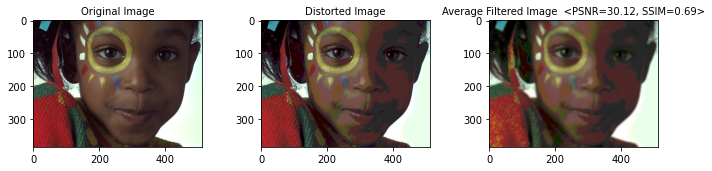

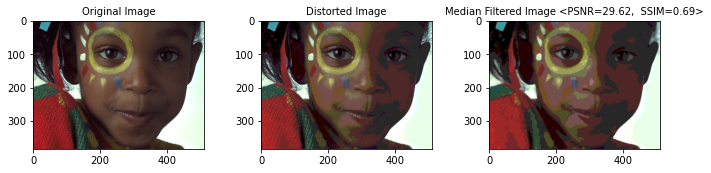

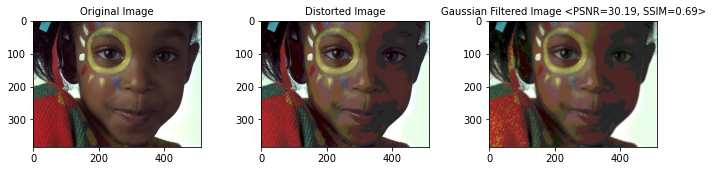

In [31]:
# mean filter
mean_den_image = mean_filter(add_gauss_images[72], 7)
psnr1 = PSNR(orig_images[14], mean_den_image)
ssim1 = SSIM(orig_images[14], mean_den_image)
# median filter 
med_den_image = median_filter(add_gauss_images[72], 7)
psnr2 = PSNR(orig_images[14], med_den_image)
ssim2 = SSIM(orig_images[14], mean_den_image)
# gaussian filter
gaus_den_image = gaussian_filter(add_gauss_images[72],7)
psnr3 = PSNR(orig_images[14], gaus_den_image)
ssim3 = SSIM(orig_images[14], mean_den_image)

plot_images(orig_images[14],add_gauss_images[72] , mean_den_image, f'Average Filtered Image  <PSNR={psnr1}, SSIM={ssim1}>')
plot_images(orig_images[14], add_gauss_images[72], med_den_image, f'Median Filtered Image <PSNR={psnr2},  SSIM={ssim2}>')
plot_images(orig_images[14], add_gauss_images[72], gaus_den_image, f'Gaussian Filtered Image <PSNR={psnr3}, SSIM={ssim3}>')

##  Plot metrics for all images

# PSNR

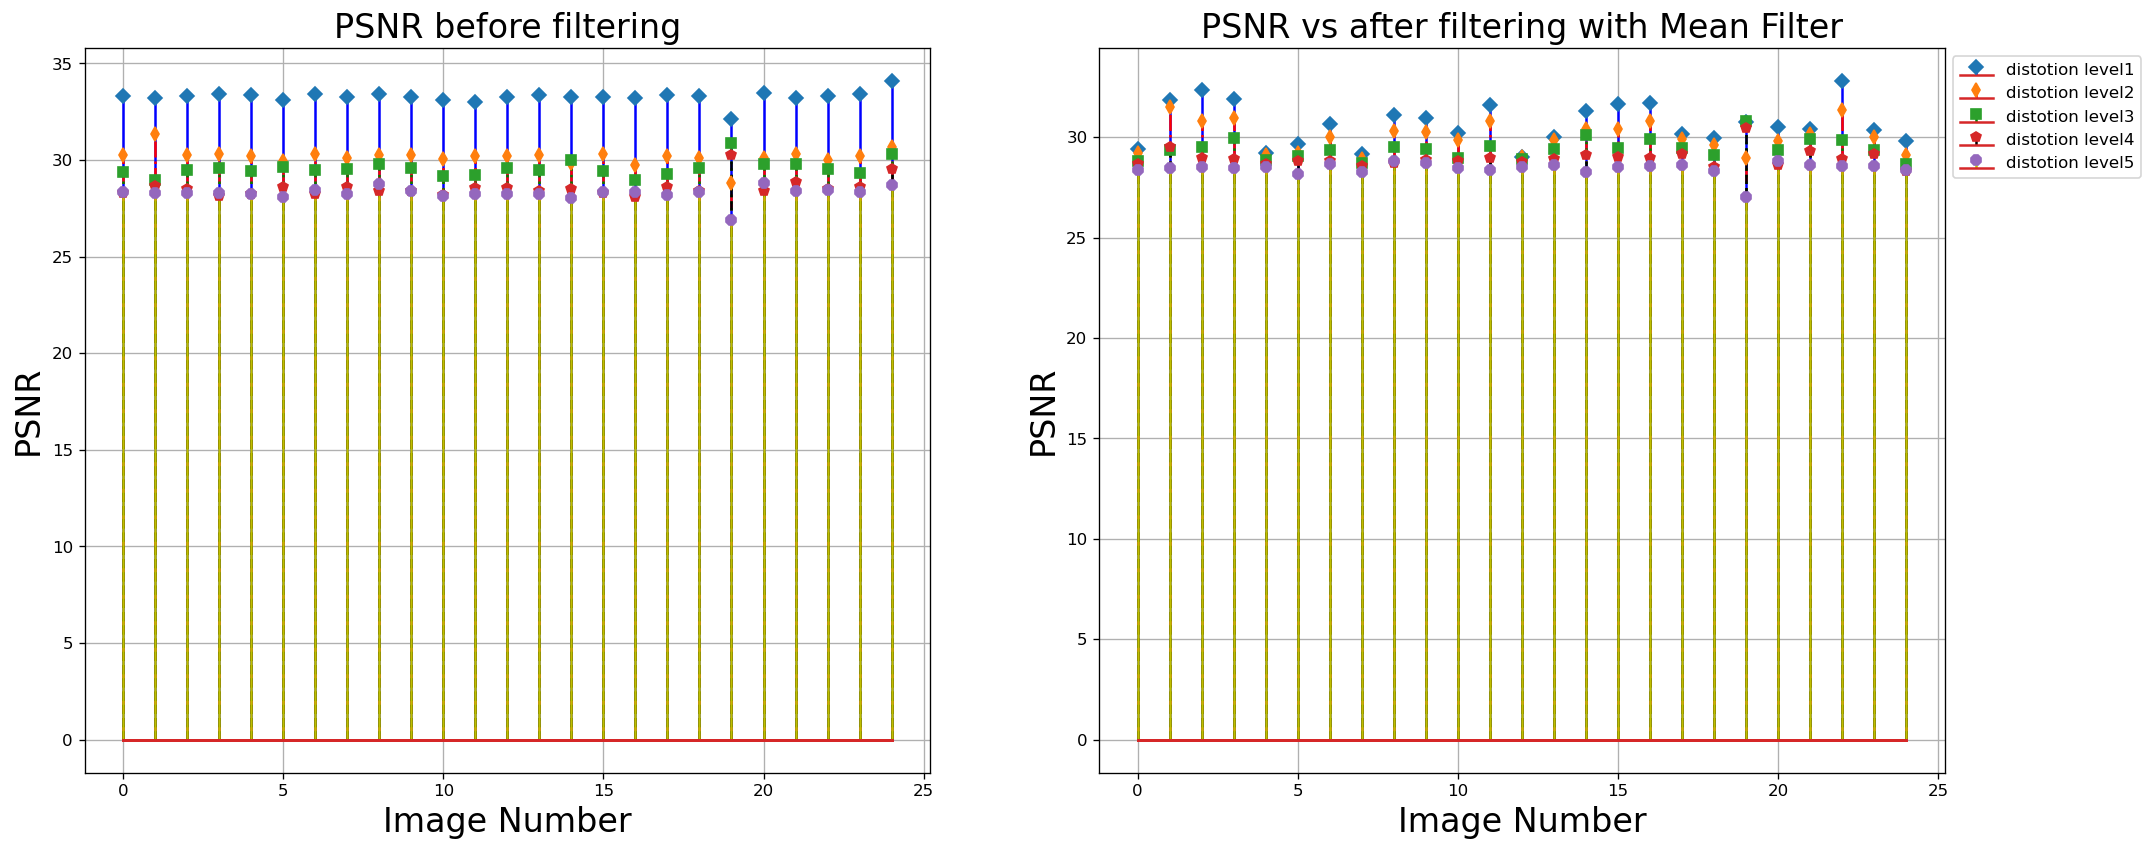

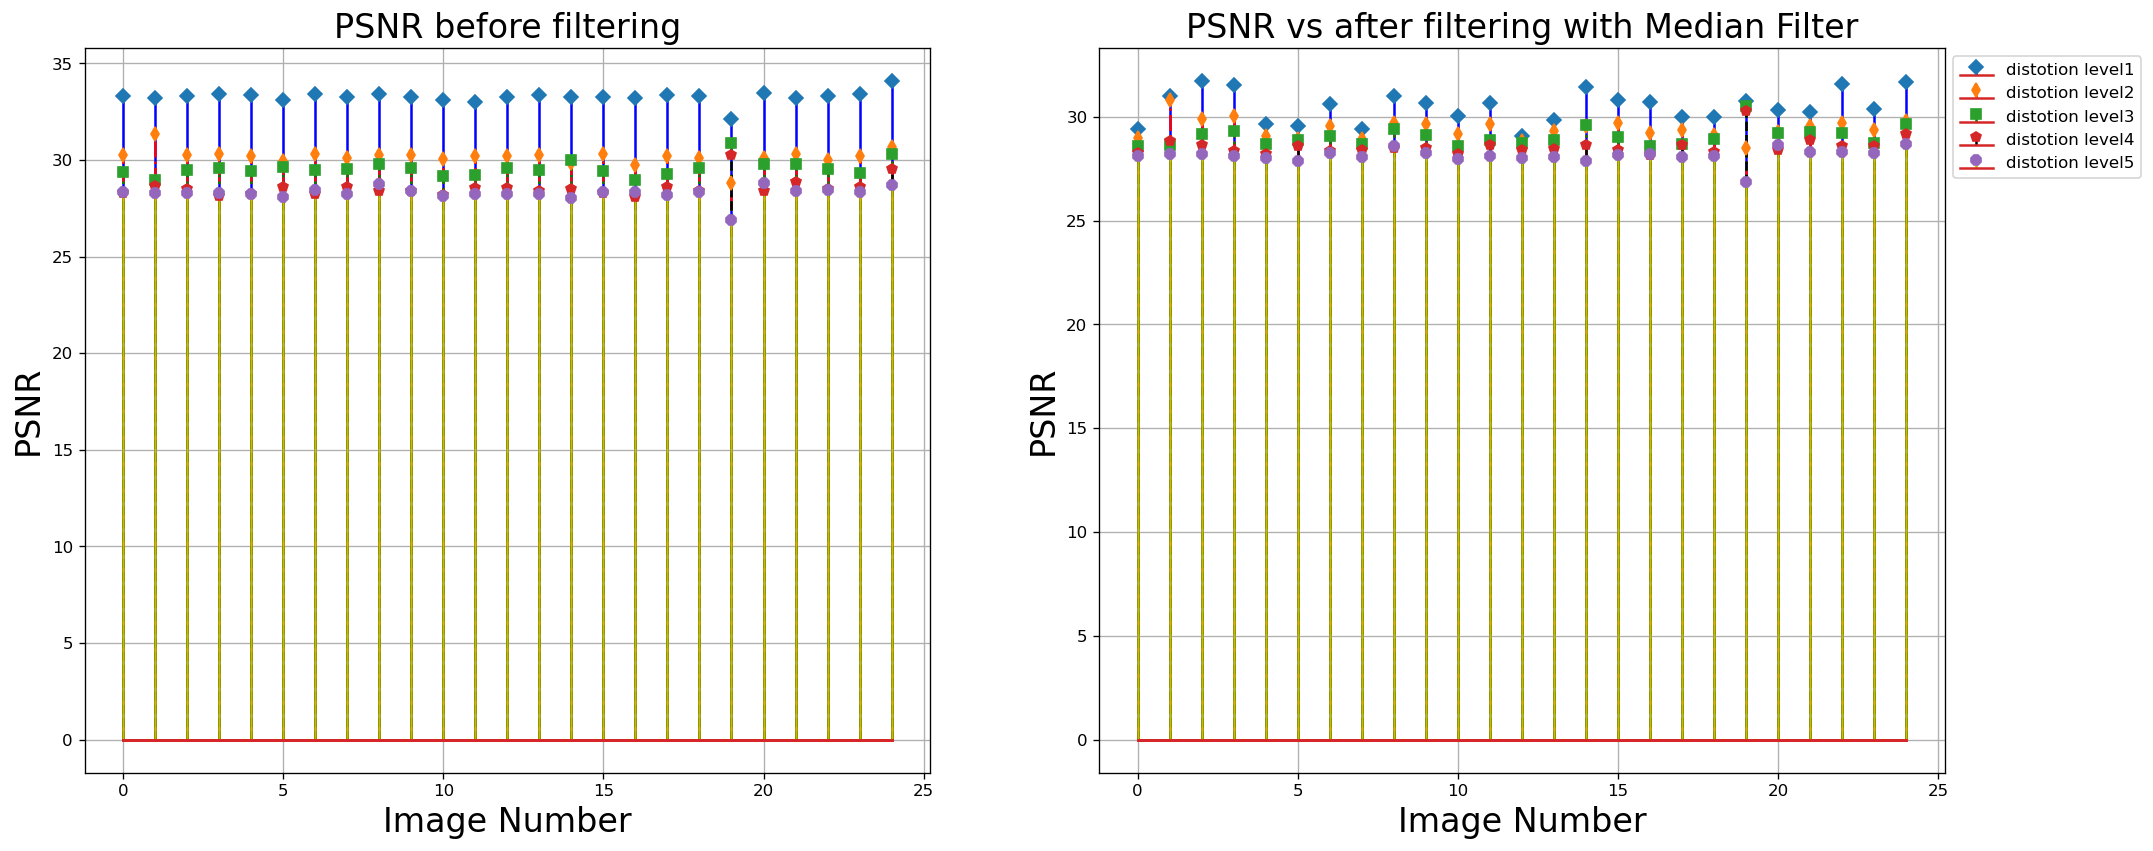

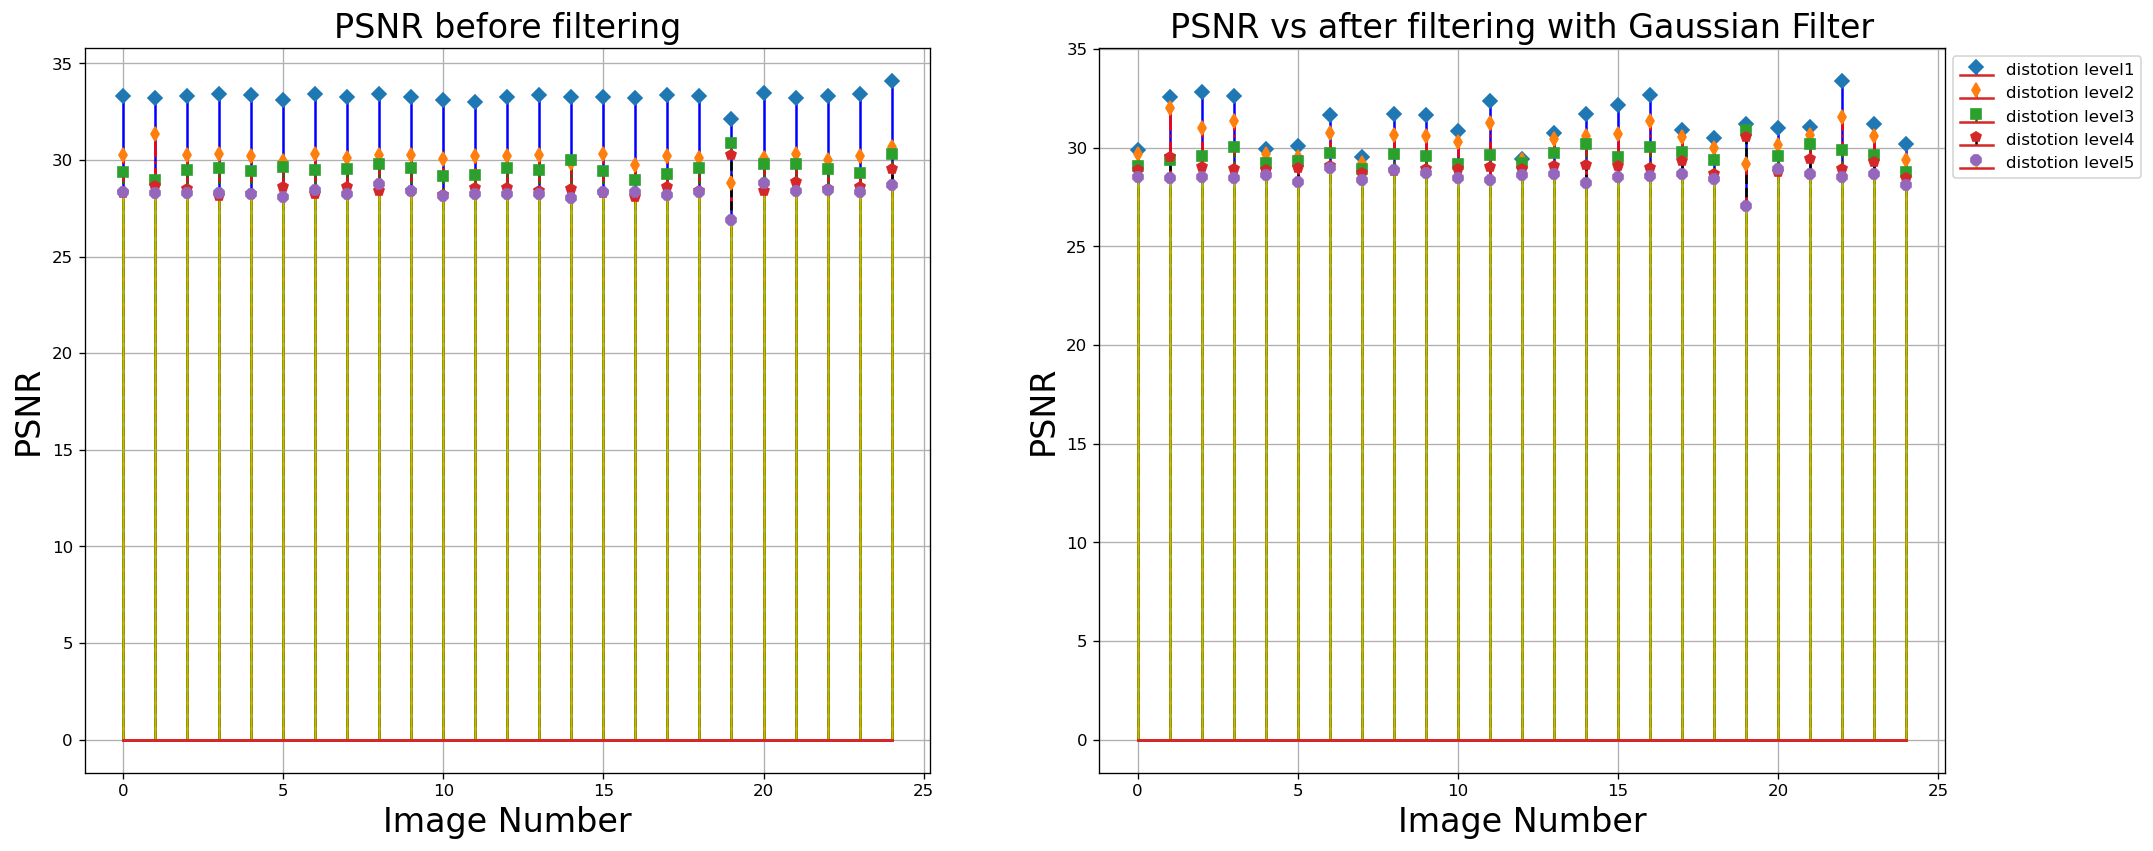

In [31]:
plot_all_images_metrics(orig_images,group_data(add_gauss_images), PSNR,
                        mean_filter, 
                        'PSNR vs after filtering with Mean Filter',
                        'PSNR before filtering', 'PSNR'),
plot_all_images_metrics(orig_images,group_data(add_gauss_images), PSNR,
                        median_filter, 
                        'PSNR vs after filtering with Median Filter',
                        'PSNR before filtering', 'PSNR')
plot_all_images_metrics(orig_images,group_data(add_gauss_images), PSNR,
                        gaussian_filter, 
                        'PSNR vs after filtering with Gaussian Filter',
                        'PSNR before filtering', 'PSNR')

# SSIM

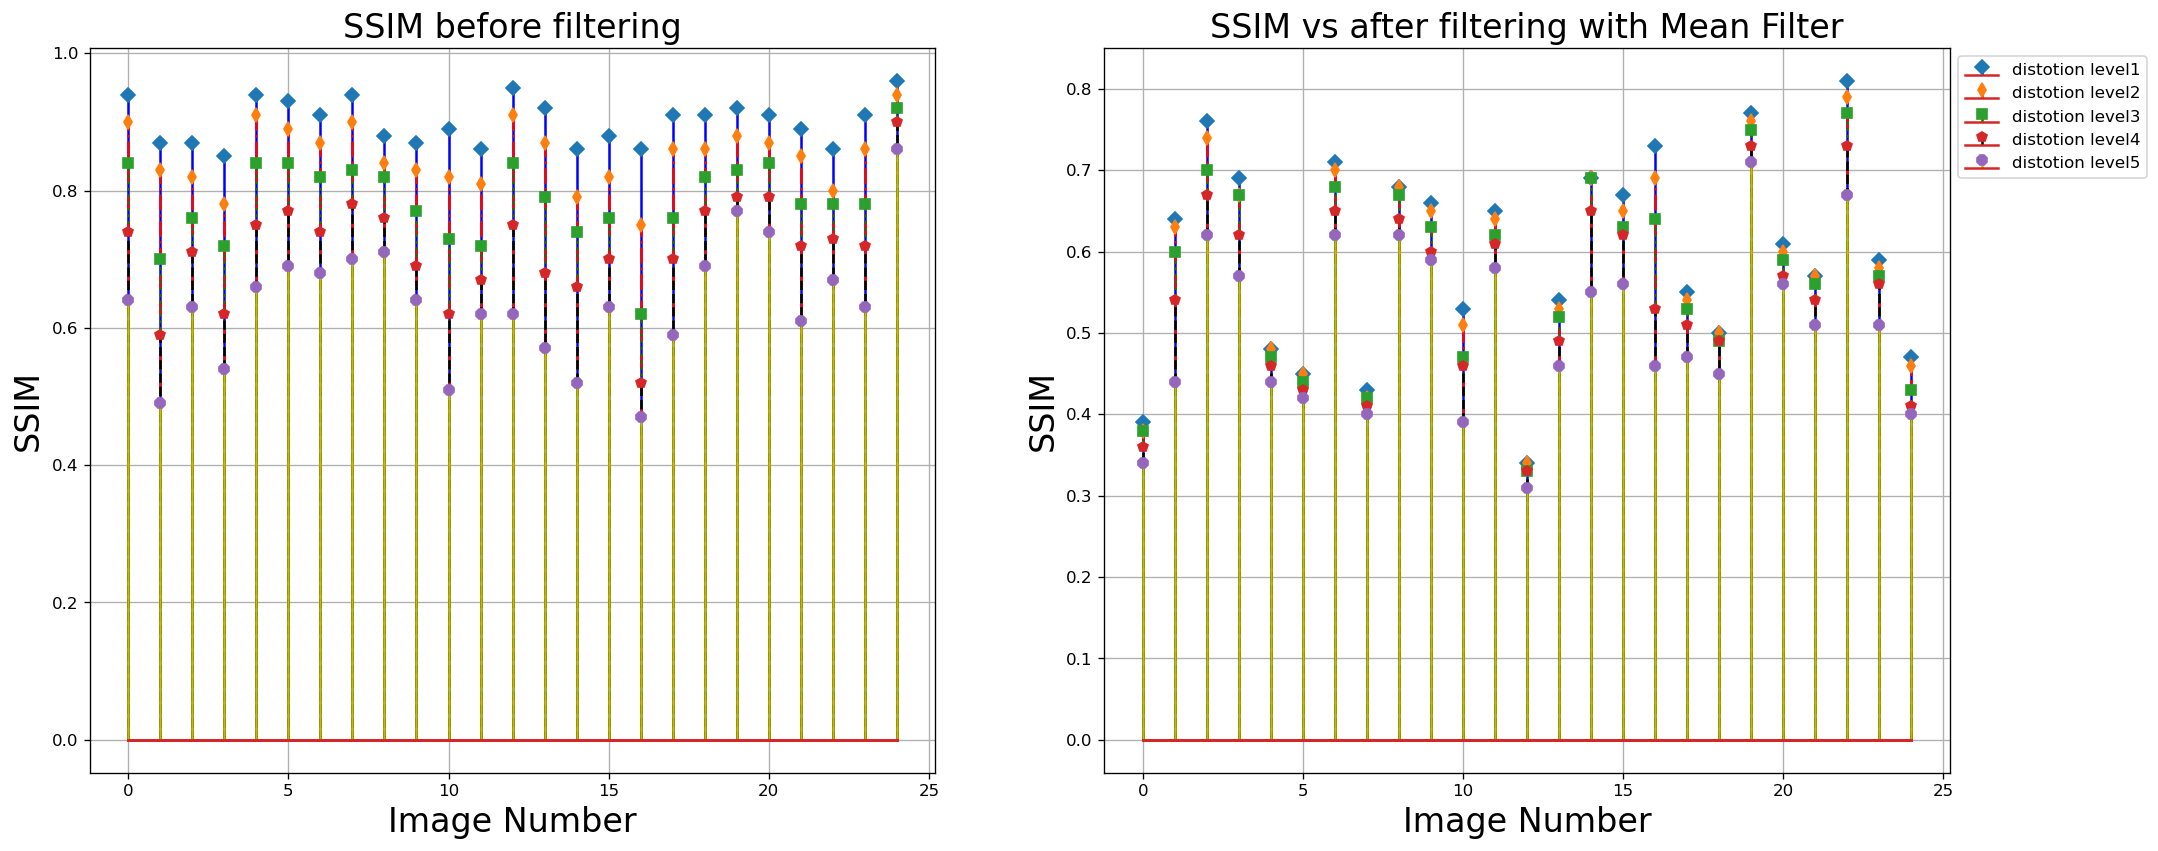

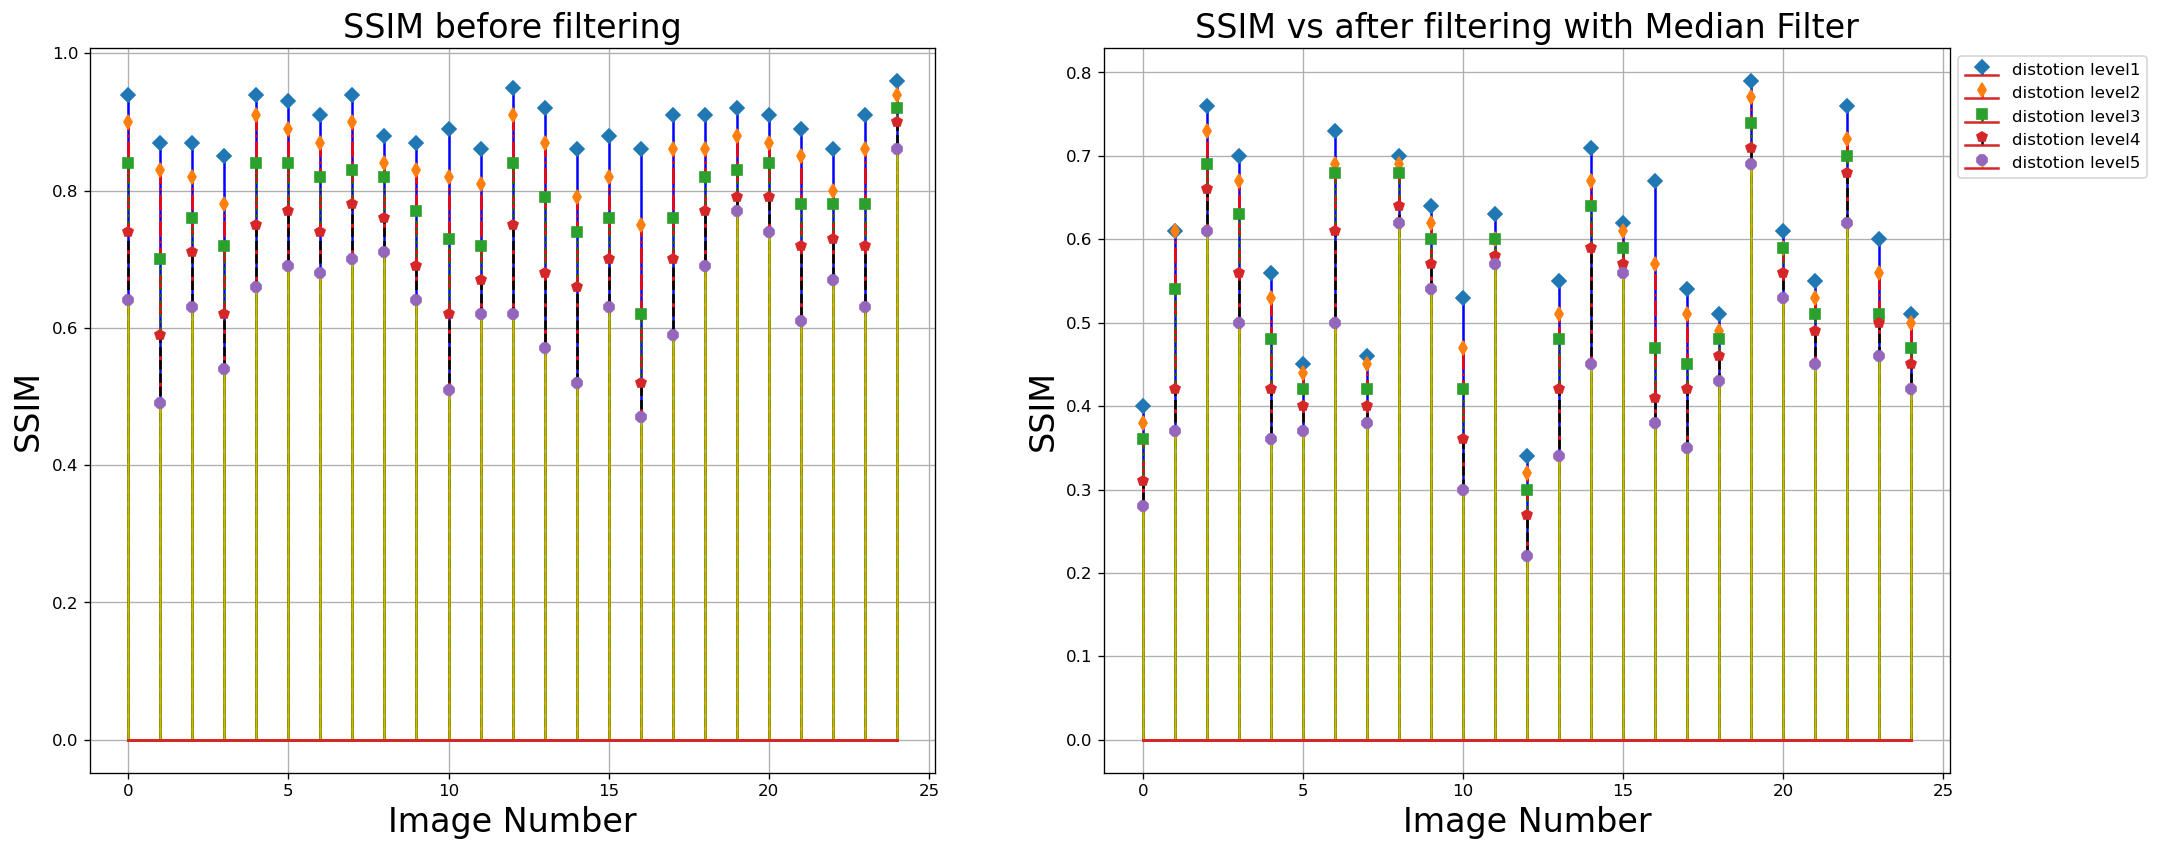

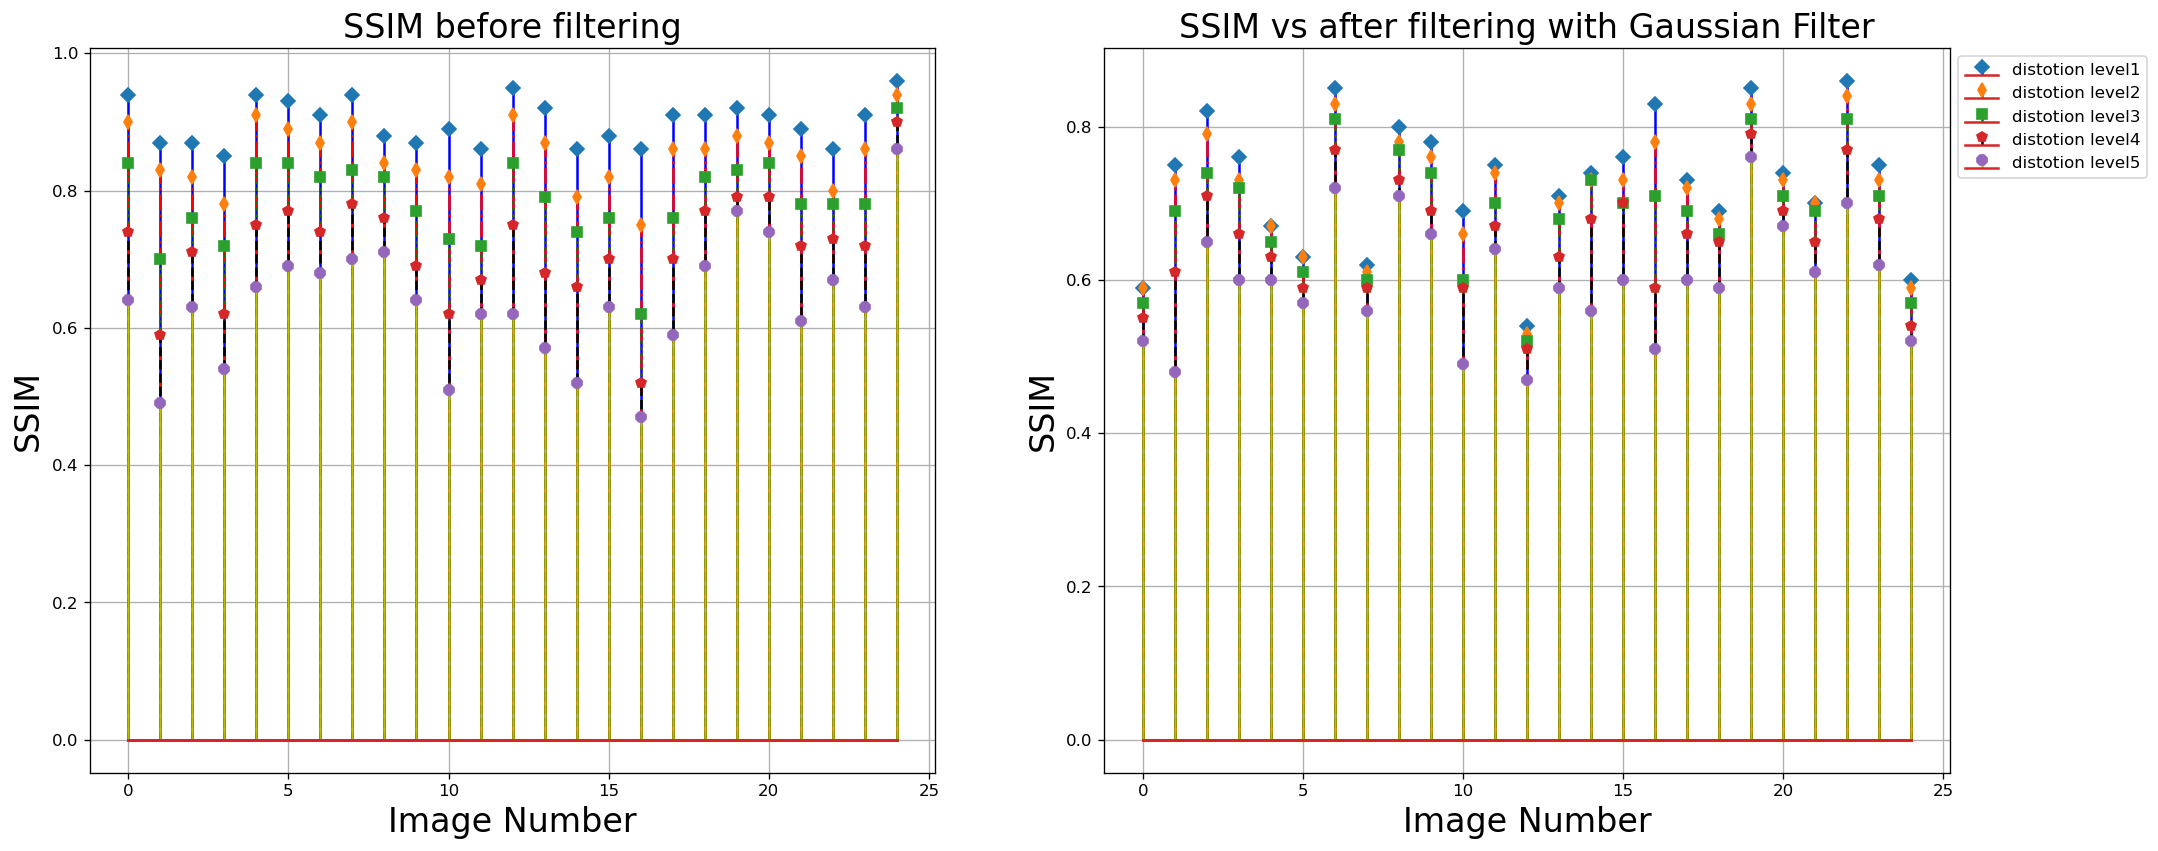

In [32]:
plot_all_images_metrics(orig_images,group_data(add_gauss_images), SSIM,
                        mean_filter, 
                        'SSIM vs after filtering with Mean Filter',
                        'SSIM before filtering', 'SSIM')
plot_all_images_metrics(orig_images,group_data(add_gauss_images), SSIM,
                        median_filter, 
                        'SSIM vs after filtering with Median Filter',
                        'SSIM before filtering', 'SSIM')
plot_all_images_metrics(orig_images,group_data(add_gauss_images), SSIM,
                        gaussian_filter, 
                        'SSIM vs after filtering with Gaussian Filter',
                        'SSIM before filtering', 'SSIM')

# Plot metrics vs kernel size

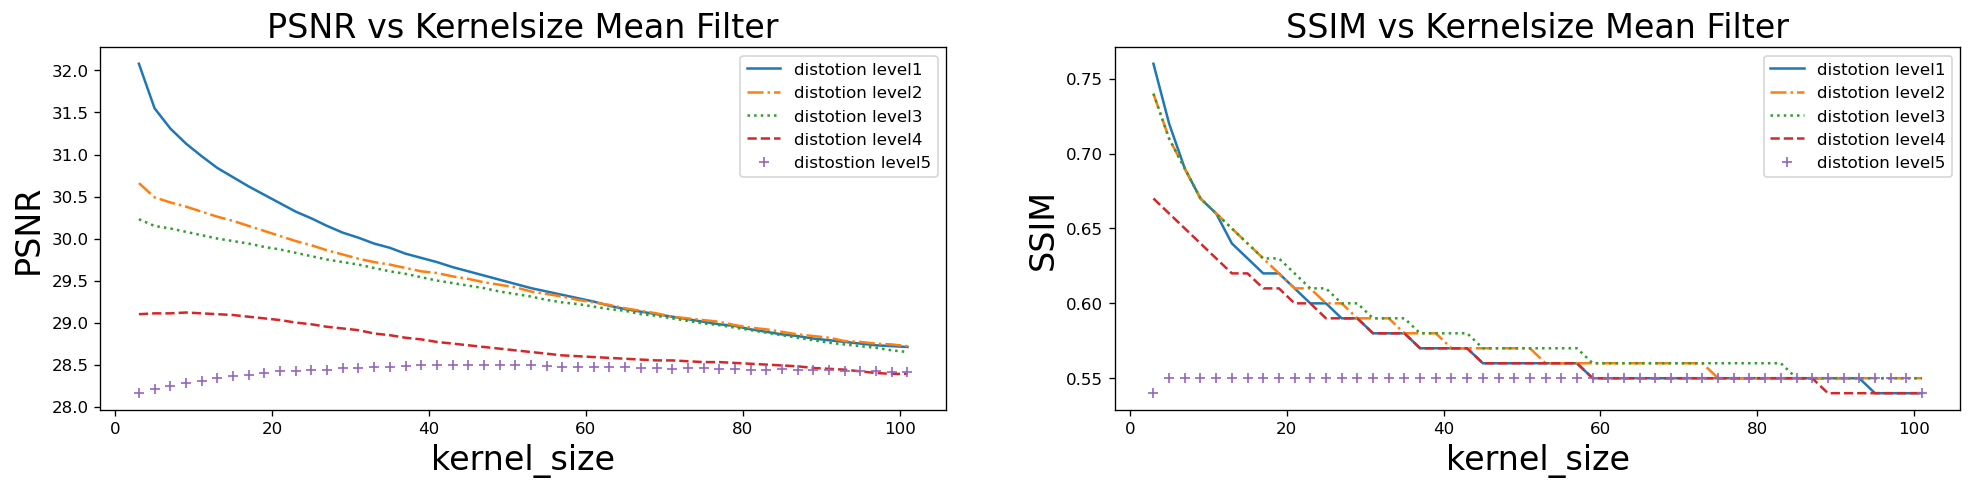

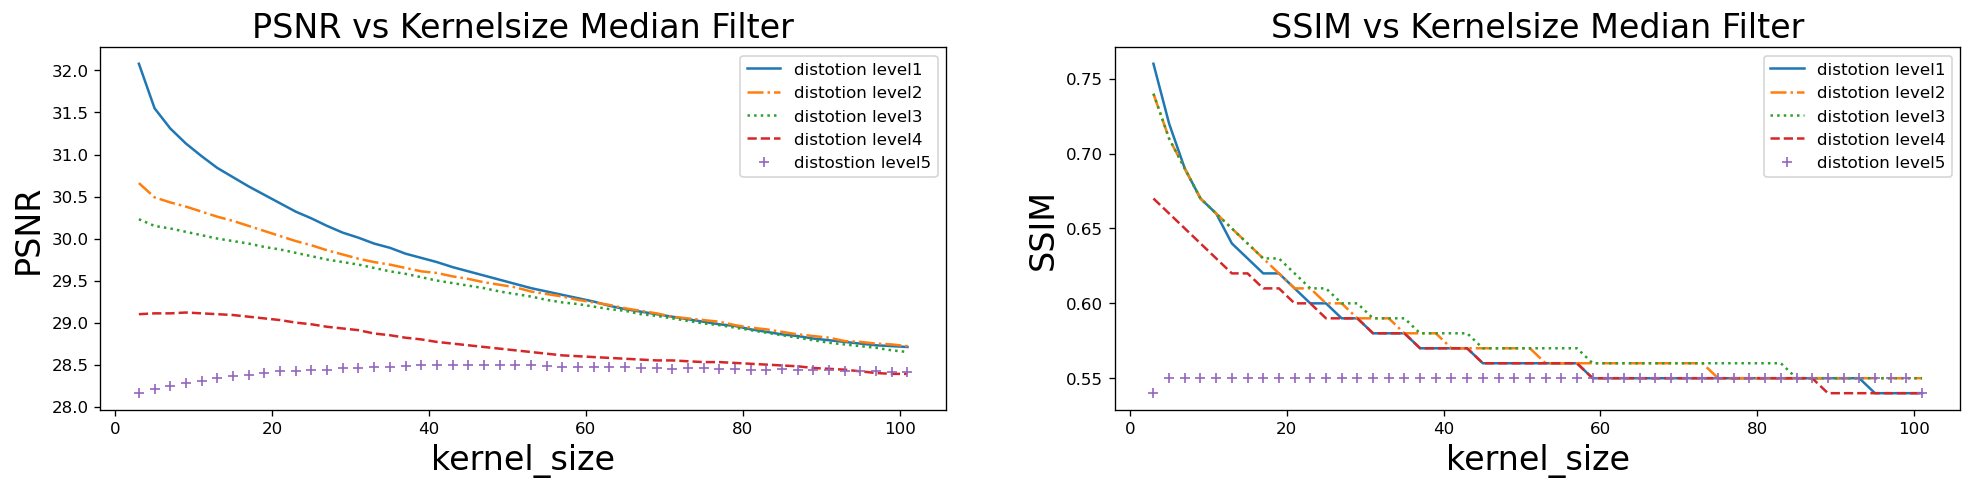

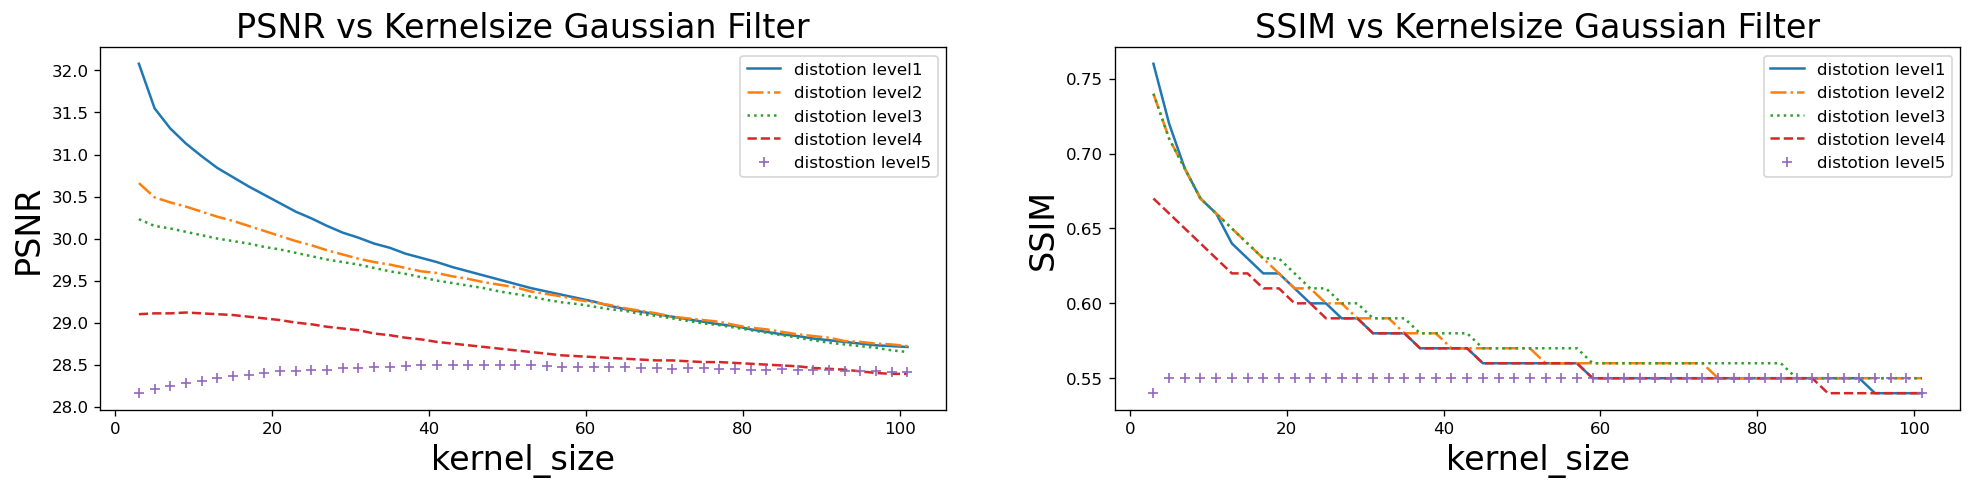

In [33]:
plot_kernel_size_metrics(orig_images[14], add_gauss_images[70:75],PSNR,SSIM, mean_filter, 
                         'PSNR vs Kernelsize Mean Filter','SSIM vs Kernelsize Mean Filter')
plot_kernel_size_metrics(orig_images[14], add_gauss_images[70:75],PSNR,SSIM, mean_filter, 
                         'PSNR vs Kernelsize Median Filter','SSIM vs Kernelsize Median Filter')
plot_kernel_size_metrics(orig_images[14], add_gauss_images[70:75],PSNR,SSIM, mean_filter, 
                         'PSNR vs Kernelsize Gaussian Filter','SSIM vs Kernelsize Gaussian Filter')

# Plot Intensity  distributions before and after filtering

In [34]:
den_images = denoised_images(orig_images[14], add_gauss_images[70:75], median_filter)

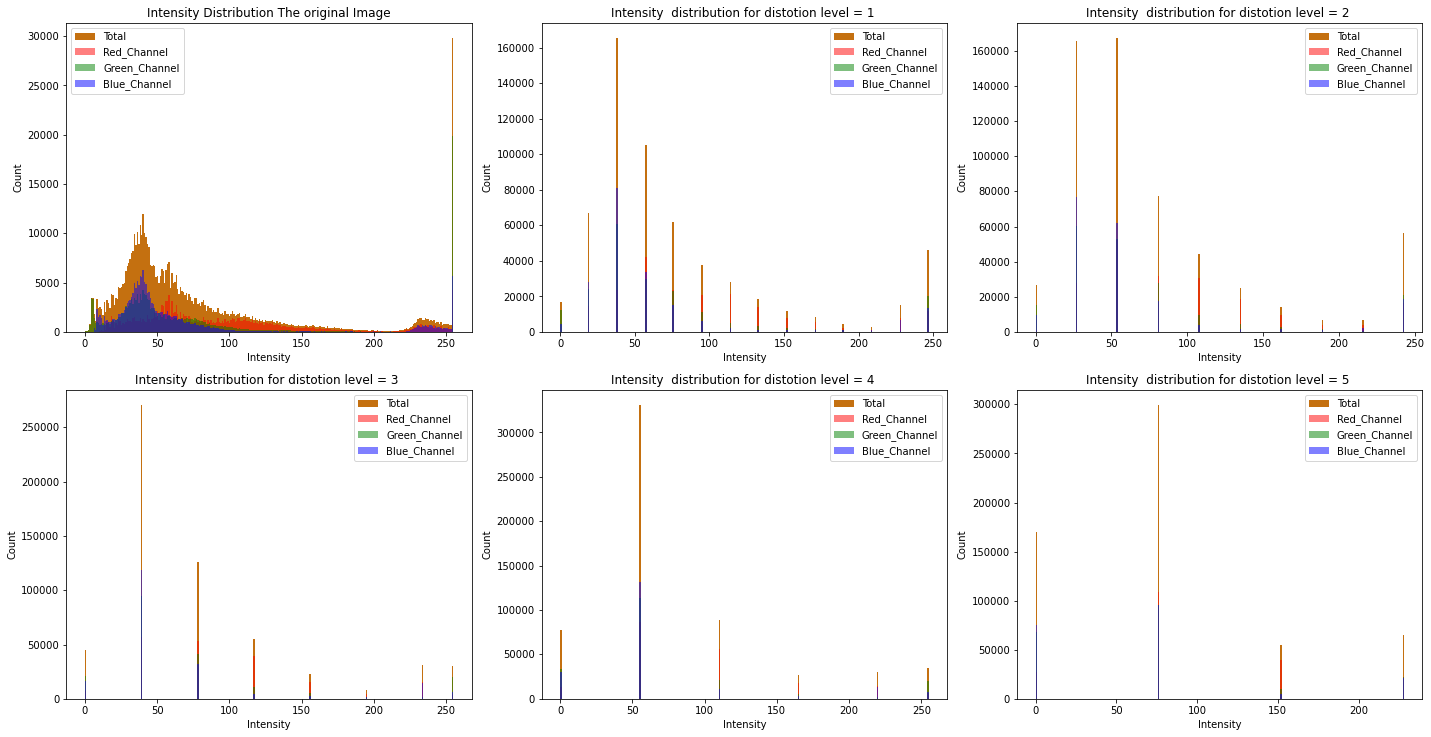

In [35]:
plot_intensity_distributions(orig_images[14:15] + add_gauss_images[70:75])

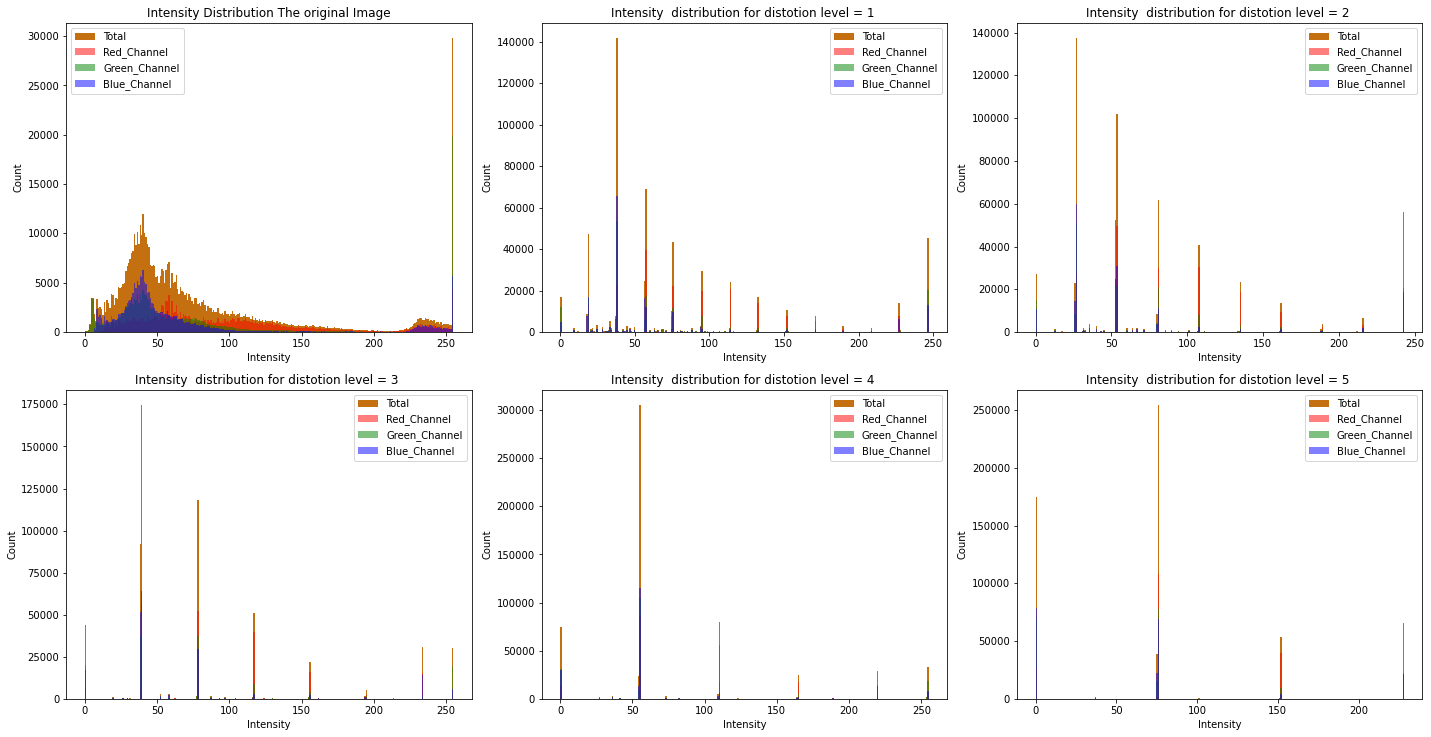

In [36]:
plot_intensity_distributions(orig_images[14:15]  + den_images[0:5])